In [1]:
#%%
# Import required modules
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
from torch.distributions.independent import Independent
from lightning_data_modules.SyntheticDataset import SyntheticDataModule
from lightning_modules.BaseSdeGenerativeModel import BaseSdeGenerativeModel
from lightning_modules.FokkerPlanckModel import FokkerPlanckModel
#from lightning_modules.ConservativeSdeGenerativeModel import ConservativeSdeGenerativeModel
from models.fcn_potential import FCN_Potential
from models.fcn import FCN
from models.utils import get_score_fn
from utils import compute_divergence, compute_grad, compute_curl, generate_grid, extract_vector_field, fisher_divergence
from plot_utils import plot_log_energy
import sde_lib

In [2]:
def calculate_wasserstein(batch1, batch2):
    import ot
    n_batch = batch1.shape[0]
    cost_matrix = torch.cdist(batch1, batch2) ** 2
    weights = torch.ones(n_batch)/n_batch
    wasserstein = float(ot.emd2(weights, weights, cost_matrix, numItermax=int(1e6)))
    return wasserstein

In [3]:
def visualise_samples(samples, title='samples', force_range=False):
    samples_np =  samples.cpu().numpy()
    plt.figure(figsize=(10,10))
    image = plt.scatter(samples_np[:,0],samples_np[:,1])
    if force_range:
        plt.ylim(-1.5,1.5)
        plt.xlim(-1.5,1.5)
    #plt.gca().set_aspect('equal')
    plt.axis('square')
    plt.savefig('figures/'+title, dpi=300)

In [4]:
def print_sampling_parameters(config):
    sampling = config.sampling
    model = config.model
    print('predictor:', sampling.predictor)
    print('num_time_steps', model.num_scales)
    print('corrector:', sampling.corrector)
    print('snr:',  sampling.snr)
    print('n_steps_each:', sampling.n_steps_each)
    print('probability_flow:', sampling.probability_flow)
    print('noise_removal:', sampling.noise_removal)

In [5]:
def get_sampling_config(config, snr=0.075, predictor='reverse_diffusion', corrector = 'none', 
                n_steps_each=1, probability_flow=False, num_scales=1000):
    
    sampling = config.sampling
    sampling.corrector = 'pc'
    sampling.predictor =  predictor
    sampling.corrector = corrector
    sampling.n_steps_each = n_steps_each
    sampling.noise_removal = True
    sampling.probability_flow = probability_flow
    sampling.snr = snr

    model = config.model
    model.num_scales = num_scales

    return config

In [6]:
def sample(ckpt_path, sampling_config):
    from sampling.unconditional import get_sampling_fn
    pl_module = FokkerPlanckModel.load_from_checkpoint(ckpt_path)
    score_model = pl_module.score_model
    pl_module.configure_sde(config)
    pl_module = pl_module.eval()

    num_samples = 5000   
    sde = sde_lib.VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales, data_mean=None) #pl_module.sde
    sampling_eps = 1e-5
    sampling_shape = [num_samples] +  config.data.shape
    sampling_fn = get_sampling_fn(config, sde, sampling_shape, sampling_eps)
    score_model = pl_module.score_model
    samples, _ = sampling_fn(score_model)#, show_evolution=False)
    return samples

# Tests

In [7]:
import torch.nn as nn
import pytorch_lightning as pl
class GTModel(pl.LightningModule):
    def __init__(self, gt_fn):
        super().__init__()
        self.gt_fn = gt_fn

    def forward(self, x, t):
        return self.gt_fn(x, t)


In [19]:
from configs.jan.gaussian.fokker_planck_gauss import get_config
from lightning_data_modules.SyntheticDataset import SyntheticDataModule
from sampling.unconditional import get_sampling_fn
config = get_config()
data_m = SyntheticDataModule(config)
data_m.setup()
dataset = data_m.dataset
num_samples = 1000  
sde = dataset.sde
sampling_eps = 1e-5
sampling_shape = [num_samples] +  config.data.shape
gamma = 1
gt_score_fn = lambda x,t: gamma * dataset.ground_truth_score(x,t)
score_model = GTModel(gt_score_fn)
sampling_fn = get_sampling_fn(config, sde, sampling_shape, sampling_eps)
samples, _ = sampling_fn(score_model)

100%|██████████| 1000/1000 [00:06<00:00, 143.95it/s]


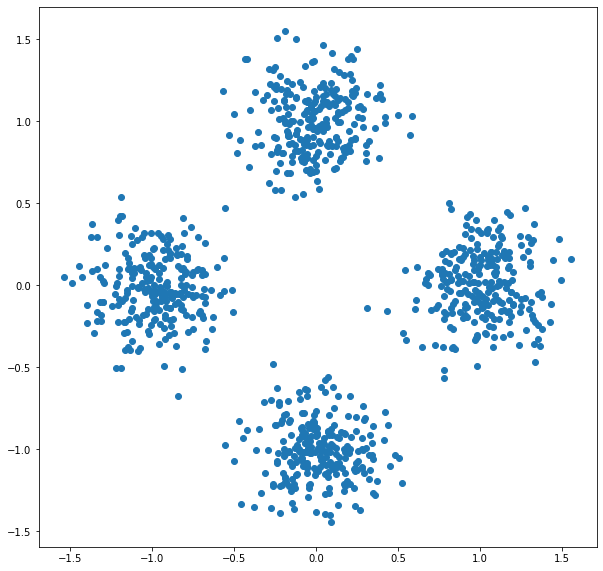

In [20]:
visualise_samples(samples)

# Gaussian Mixtures

## Fokker-Planck Model

In [7]:
from configs.jan.gaussian.fokker_planck_gauss import get_config
config = get_config()
ckpt_path = "logs/gaussian_bubbles/fokker_planck/fp_grad-alpha_0_0001_to_0_01_deep/checkpoints/best/last.ckpt"

100%|██████████| 1000/1000 [00:06<00:00, 160.12it/s]


predictor: reverse_diffusion
num_time_steps 1000
corrector: none
snr: 0.075
n_steps_each: 1
probability_flow: False
noise_removal: True


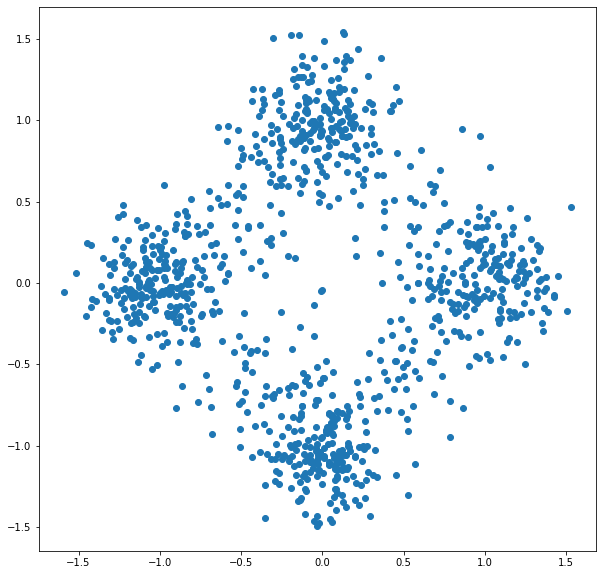

In [8]:
config = get_config()
samples = sample(ckpt_path,config)
visualise_samples(samples)
print_sampling_parameters(config)

100%|██████████| 1000/1000 [00:05<00:00, 178.15it/s]


predictor: reverse_diffusion
num_time_steps 1000
corrector: none
snr: 0.075
n_steps_each: 1
probability_flow: True
noise_removal: True


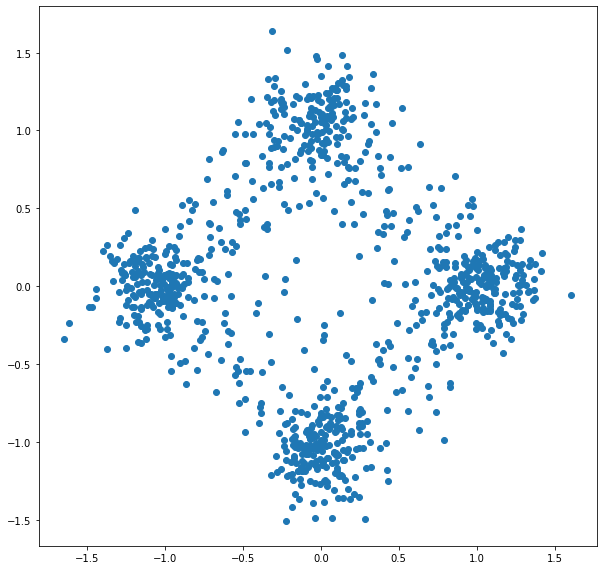

In [82]:
config_ode = get_sampling_config(config, probability_flow=True)
samples_ode = sample(ckpt_path, config_ode)
visualise_samples(samples_ode)
print_sampling_parameters(config_ode)

In [83]:
calculate_wasserstein(samples, samples_ode)

0.0864192321896553

## Potential

In [1]:
from configs.jan.gaussian.fokker_planck_gauss import get_config
config = get_config()
ckpt_path = 'logs/gaussian_bubbles/fokker_planck/fp_grad-alpha_0/checkpoints/best/last.ckpt'

100%|██████████| 1000/1000 [00:05<00:00, 173.35it/s]


predictor: reverse_diffusion
num_time_steps 1000
corrector: none
snr: 0.075
n_steps_each: 1
probability_flow: False
noise_removal: True


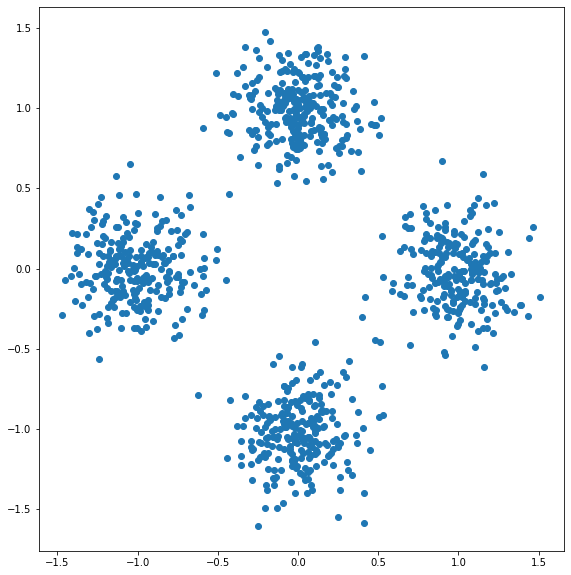

In [85]:
config = get_config()
samples = sample(ckpt_path,config)
visualise_samples(samples)
print_sampling_parameters(config)

100%|██████████| 1000/1000 [00:05<00:00, 188.73it/s]


predictor: reverse_diffusion
num_time_steps 1000
corrector: none
snr: 0.075
n_steps_each: 1
probability_flow: True
noise_removal: True


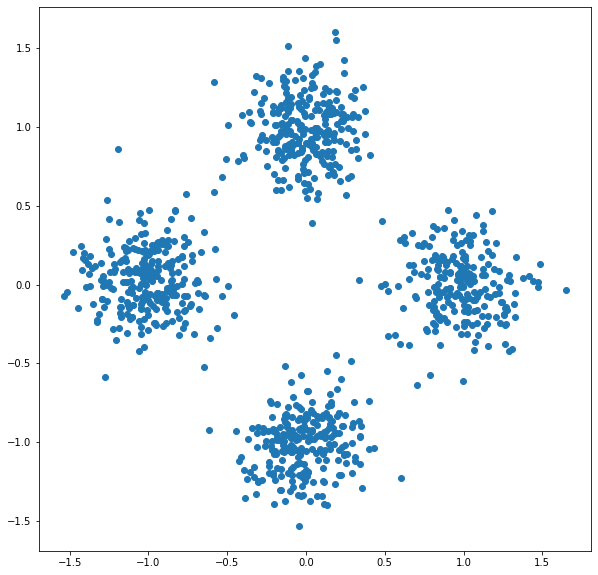

In [86]:
config_ode = get_sampling_config(config, probability_flow=True)
samples_ode = sample(ckpt_path, config_ode)
visualise_samples(samples_ode)
print_sampling_parameters(config_ode)

In [87]:
calculate_wasserstein(samples, samples_ode)

0.06886526197195053

# Circles

## Potential

In [7]:
#from configs.jan.circles.fokker_planck.fokker_planck_circles import get_config 
from configs.fokker_planck.fokker_planck import get_config
config = get_config()
ckpt_path = 'logs/fokker_planck/fp_0/checkpoints/best/last.ckpt'

#ckpt_path = 'logs/fokker_planck/fp_0.001/checkpoints/best/last.ckpt'

#'logs/circles/fokker_planck/fp_grad-alpha_0_deep/checkpoints/best/last.ckpt'
#'logs/circles/fokker_planck/fp_ve_alpha_0/checkpoints/epoch=13317-step=1065439.ckpt'

In [ ]:
config = get_config()
samples = sample(ckpt_path,config)

predictor: reverse_diffusion
num_time_steps 1000
corrector: none
snr: 0.075
n_steps_each: 1
probability_flow: True
noise_removal: True


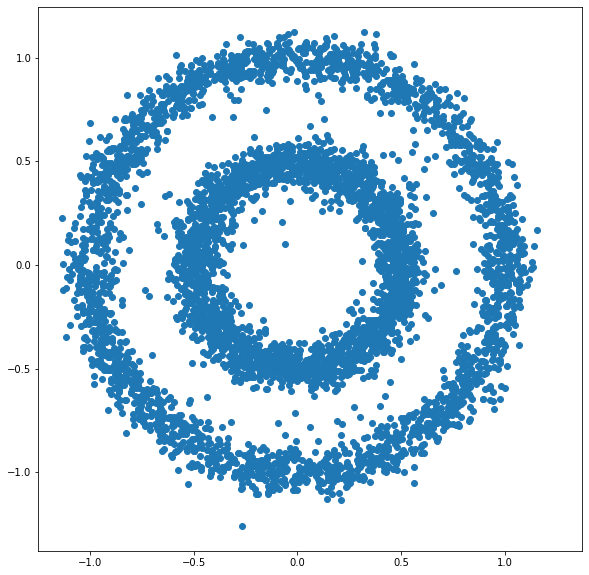

In [11]:
samples = samples[torch.linalg.norm(samples, dim=1) < 1.5]
visualise_samples(samples, title='title')
print_sampling_parameters(config)

In [14]:
config_ode = get_sampling_config(config, probability_flow=True)
samples_ode = sample(ckpt_path, config_ode)

100%|██████████| 1000/1000 [00:11<00:00, 86.83it/s]


predictor: reverse_diffusion
num_time_steps 1000
corrector: none
snr: 0.075
n_steps_each: 1
probability_flow: True
noise_removal: True


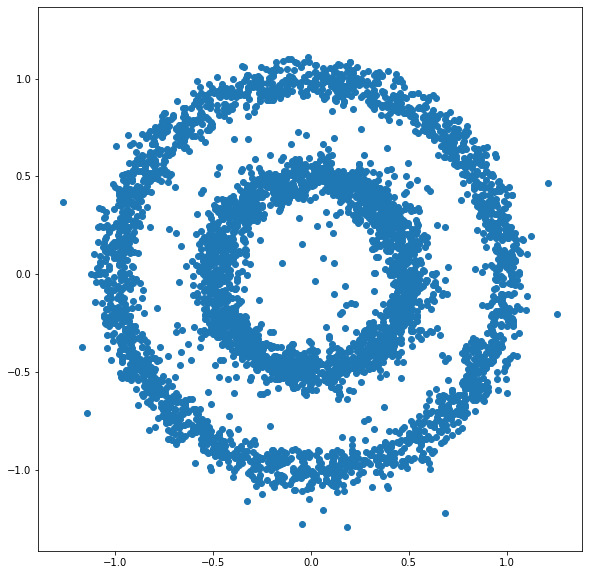

In [15]:
samples_ode = samples_ode[torch.linalg.norm(samples_ode, dim=1) < 1.5]
visualise_samples(samples_ode, title='title')
print_sampling_parameters(config_ode)

In [11]:
calculate_wasserstein(samples, samples_ode)

0.01993657648563385

## Fokker Planck

In [32]:
#from configs.jan.circles.fokker_planck.fokker_planck_circles import get_config 
from configs.fokker_planck.fokker_planck import get_config
config = get_config()
ckpt_path = 'logs/fokker_planck/fp_0.001/checkpoints/best/last.ckpt'

In [33]:
config = get_config()
samples = sample(ckpt_path,config)

100%|██████████| 1000/1000 [00:18<00:00, 54.82it/s]


predictor: reverse_diffusion
num_time_steps 1000
corrector: none
snr: 0.075
n_steps_each: 1
probability_flow: False
noise_removal: True


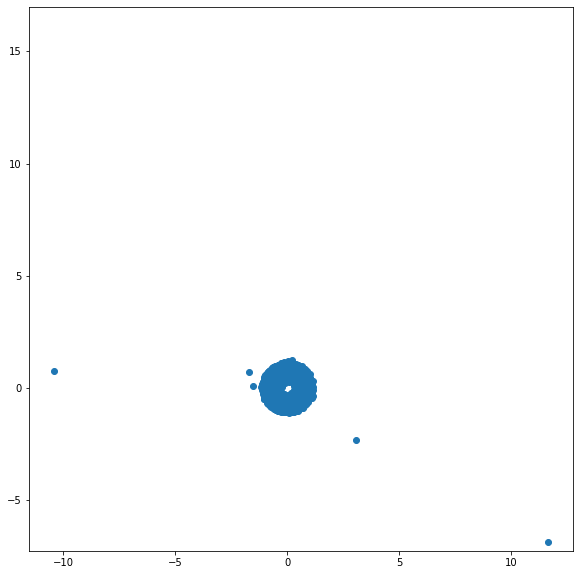

In [34]:
#samples = samples[torch.linalg.norm(samples, dim=1) < 1.5]
visualise_samples(samples, title='title')
print_sampling_parameters(config)

In [37]:
config_ode = get_sampling_config(config, probability_flow=True)
samples_ode = sample(ckpt_path, config_ode)

 78%|███████▊  | 780/1000 [00:11<00:03, 73.21it/s]

predictor: reverse_diffusion
num_time_steps 1000
corrector: none
snr: 0.075
n_steps_each: 1
probability_flow: True
noise_removal: True


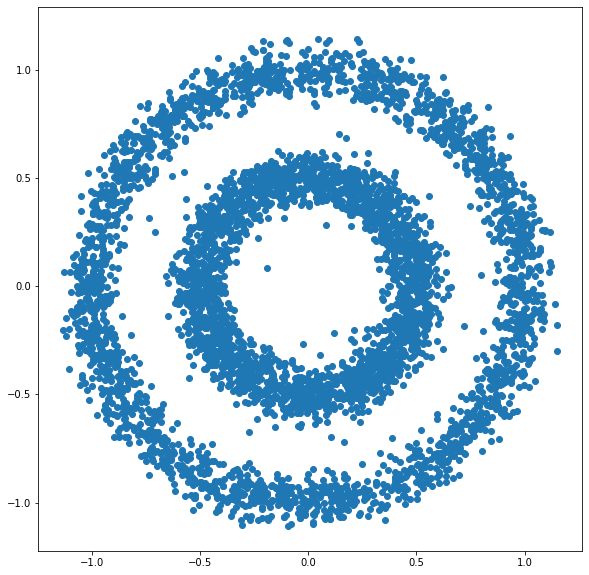

In [ ]:
#samples_ode = samples_ode[torch.linalg.norm(samples_ode, dim=1) < 1.5]
visualise_samples(samples_ode, title='title')
print_sampling_parameters(config_ode)

# Vanilla

In [58]:
from configs.jan.circles.fokker_planck.fokker_planck_circles import get_config 
config = get_config()
ckpt_path = 'logs/circles/fokker_planck/proto/vanilla_temp/checkpoints/best/last.ckpt'
#"logs/circles/fokker_planck/fp_grad-alpha_0_01_deep_resumed/checkpoints/best/last.ckpt"
#'logs/circles/fokker_planck/fp_grad-alpha_0_0001_to_0_01_deep/checkpoints/best/last.ckpt'

100%|██████████| 1000/1000 [00:12<00:00, 83.31it/s]


predictor: reverse_diffusion
num_time_steps 1000
corrector: none
snr: 0.075
n_steps_each: 1
probability_flow: False
noise_removal: True


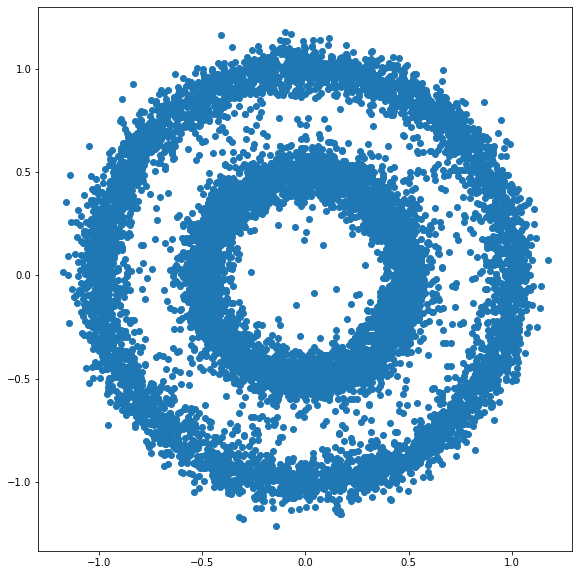

In [59]:
config = get_config()
samples = sample(ckpt_path,config)
visualise_samples(samples)
print_sampling_parameters(config)

100%|██████████| 1000/1000 [00:11<00:00, 87.73it/s]


predictor: reverse_diffusion
num_time_steps 1000
corrector: none
snr: 0.075
n_steps_each: 1
probability_flow: True
noise_removal: True


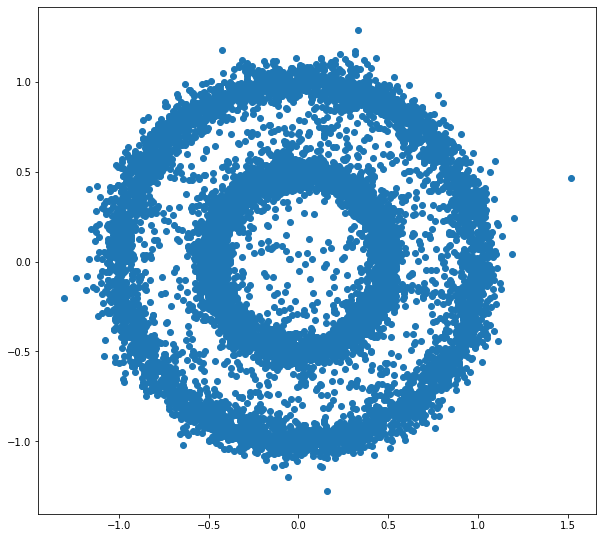

In [60]:
config_ode = get_sampling_config(config, probability_flow=True)
samples_ode = sample(ckpt_path, config_ode)
visualise_samples(samples_ode)
print_sampling_parameters(config_ode)

In [61]:
calculate_wasserstein(samples, samples_ode)

0.0010741247097030282